In [24]:
import pandas as pd
import optuna
import sys
from sklearn.metrics import root_mean_squared_error, r2_score
from sklearn.ensemble import GradientBoostingRegressor
import numpy as np
import matplotlib.pyplot as plt
import shap 
sys.path.append('../scripts')
import problem

# Import des données

In [25]:
ROI_train = pd.read_csv("../data/train_rois.csv")
ROI_test = pd.read_csv("../data/test_rois.csv")

In [26]:
ROI_train.shape

(357, 288)

In [27]:
participants_train = pd.read_csv("../data/train_participants.csv")

In [28]:
X_train, y_train = problem.get_train_data(True)
X_test, y_test = problem.get_test_data(True)

assert X_train.shape[1] == 284 + 331695

# Séparation des variables en 5 zones : 
- **Zone Corticale** : reflète les principales fonctions cognitives et sensorielles du cerveau.
- **Zone Subcorticale** et Limbique : structures sous-corticales et les régions limbiques, impliquées dans les émotions, la mémoire, et le système de récompense.
- **Zone des Ventricules et des Espaces Liquidiens** : Zones remplies de liquide cérébrospinal (CSF), essentielles pour la protection du cerveau, l'échange de nutriments, et l'élimination des déchets.
- **Zone de la Matière Blanche et Motrice** : Cette catégorie combine la matière blanche, qui facilite la communication entre différentes régions du cerveau, et les structures motrices pour la coordination et le mouvement.
- **Zone Cérébelleuse** : Catégorie distincte pour le cervelet, vu son rôle crucial dans la coordination motrice, mais également dans certaines fonctions cognitives.

In [29]:
corticale_GM = ["lAntIns_GM_Vol", "rAntIns_GM_Vol" ,
"lAntOrbGy_GM_Vol", "rAntOrbGy_GM_Vol" ,
"lFroOpe_GM_Vol", "rFroOpe_GM_Vol" ,
"lFroPo_GM_Vol", "rFroPo_GM_Vol" ,
"lMidFroGy_GM_Vol", "rMidFroGy_GM_Vol" ,
"lMedFroCbr_GM_Vol", "rMedFroCbr_GM_Vol" ,
"lSupMedFroGy_GM_Vol", "rSupMedFroGy_GM_Vol" ,
"lInfFroGy_GM_Vol", "rInfFroGy_GM_Vol" ,
"lInfFroOrbGy_GM_Vol", "rInfFroOrbGy_GM_Vol" ,
"lSupFroGy_GM_Vol", "rSupFroGy_GM_Vol" ,
"lInfFroAngGy_GM_Vol", "rInfFroAngGy_GM_Vol", 
"lAngGy_GM_Vol", "rAngGy_GM_Vol",
"lCun_GM_Vol", "rCun_GM_Vol" ,
"lInfOccGy_GM_Vol", "rInfOccGy_GM_Vol" ,
"lMidOccGy_GM_Vol", "rMidOccGy_GM_Vol" ,
"lOccPo_GM_Vol", "rOccPo_GM_Vol" ,
"lPCu_GM_Vol", "rPCu_GM_Vol" ,
"lParHipGy_GM_Vol", "rParHipGy_GM_Vol" ,
"lParOpe_GM_Vol", "rParOpe_GM_Vol" ,
"lPoCGy_GM_Vol", "rPoCGy_GM_Vol" ,
"lSupParLo_GM_Vol", "rSupParLo_GM_Vol" ,
"lOccFusGy_GM_Vol", "rOccFusGy_GM_Vol" ,
"lPosOrbGy_GM_Vol", "rPosOrbGy_GM_Vol",
"lSupOccGy_GM_Vol", "rSupOccGy_GM_Vol", 
"lEnt_GM_Vol", "rEnt_GM_Vol" ,
"lFusGy_GM_Vol", "rFusGy_GM_Vol" ,
"lInfTemGy_GM_Vol", "rInfTemGy_GM_Vol" ,
"lMidTemGy_GM_Vol", "rMidTemGy_GM_Vol" ,
"lTem_GM_Vol", "rTem_GM_Vol" ,
"lTemPo_GM_Vol", "rTemPo_GM_Vol" ,
"lTemTraGy_GM_Vol", "rTemTraGy_GM_Vol" ,
"lPosIns_GM_Vol", "rPosIns_GM_Vol",
"lPosCinGy_GM_Vol", "rPosCinGy_GM_Vol" ,
"lCenOpe_GM_Vol", "rCenOpe_GM_Vol",
"lCal+Cbr_GM_Vol", "rCal+Cbr_GM_Vol",
"lRecGy_GM_Vol", "rRecGy_GM_Vol" ,
"lLinGy_GM_Vol", "rLinGy_GM_Vol" ,
"lLatOrbGy_GM_Vol", "rLatOrbGy_GM_Vol" ,
"lMidCinGy_GM_Vol", "rMidCinGy_GM_Vol" ,
"lMedOrbGy_GM_Vol", "rMedOrbGy_GM_Vol" ,
"lMedPoCGy_GM_Vol", "rMedPoCGy_GM_Vol" ,
"lMedPrcGy_GM_Vol", "rMedPrcGy_GM_Vol" ,
"lPrcGy_GM_Vol", "rPrcGy_GM_Vol" ,
"lPla_GM_Vol", "rPla_GM_Vol" ,
"lSCA_GM_Vol", "rSCA_GM_Vol" ,
"lSupMarGy_GM_Vol", "rSupMarGy_GM_Vol", 
"lAntCinGy_GM_Vol", "rAntCinGy_GM_Vol", 
"lOC_GM_Vol", "rOC_GM_Vol"

]
corticale_CSF = ["lCenOpe_CSF_Vol", "rCenOpe_CSF_Vol" ,
"lFroOpe_CSF_Vol", "rFroOpe_CSF_Vol" ,
"lFroPo_CSF_Vol", "rFroPo_CSF_Vol",
"lMidFroGy_CSF_Vol", "rMidFroGy_CSF_Vol" ,
"lMedFroCbr_CSF_Vol", "rMedFroCbr_CSF_Vol" ,
"lSupMedFroGy_CSF_Vol", "rSupMedFroGy_CSF_Vol" ,
"lLatOrbGy_CSF_Vol", "rLatOrbGy_CSF_Vol" ,
"lMedOrbGy_CSF_Vol", "rMedOrbGy_CSF_Vol" ,
"lInfFroGy_CSF_Vol", "rInfFroGy_CSF_Vol" ,
"lInfFroOrbGy_CSF_Vol", "rInfFroOrbGy_CSF_Vol" ,
"lPosIns_CSF_Vol", "rPosIns_CSF_Vol" ,
"lSupFroGy_CSF_Vol", "rSupFroGy_CSF_Vol" ,
"lInfFroAngGy_CSF_Vol", "rInfFroAngGy_CSF_Vol" ,
"lPrcGy_CSF_Vol", "rPrcGy_CSF_Vol", 
"lInfOccGy_CSF_Vol", "rInfOccGy_CSF_Vol" ,
"lMidOccGy_CSF_Vol", "rMidOccGy_CSF_Vol" ,
"lOccPo_CSF_Vol", "rOccPo_CSF_Vol" ,
"lOccFusGy_CSF_Vol", "rOccFusGy_CSF_Vol" ,
"lCun_CSF_Vol", "rCun_CSF_Vol" ,
"lPosCinGy_CSF_Vol", "rPosCinGy_CSF_Vol" ,
"lPCu_CSF_Vol", "rPCu_CSF_Vol" ,
"lPoCGy_CSF_Vol", "rPoCGy_CSF_Vol" ,
"lParOpe_CSF_Vol", "rParOpe_CSF_Vol" ,
"lSupParLo_CSF_Vol", "rSupParLo_CSF_Vol" ,
"lSupOccGy_CSF_Vol", "rSupOccGy_CSF_Vol" ,
"lPosOrbGy_CSF_Vol", "rPosOrbGy_CSF_Vol" ,
"lInfTemGy_CSF_Vol", "rInfTemGy_CSF_Vol" ,
"lMidTemGy_CSF_Vol", "rMidTemGy_CSF_Vol" ,
"lEnt_CSF_Vol", "rEnt_CSF_Vol" ,
"lParHipGy_CSF_Vol", "rParHipGy_CSF_Vol" ,
"lTem_CSF_Vol", "rTem_CSF_Vol" ,
"lSupTemGy_CSF_Vol", "rSupTemGy_CSF_Vol" ,
"lTemPo_CSF_Vol", "rTemPo_CSF_Vol" ,
"lTemTraGy_CSF_Vol", "rTemTraGy_CSF_Vol" ,
"lOC_CSF_Vol", "rOC_CSF_Vol" ,
"lAntCinGy_CSF_Vol", "rAntCinGy_CSF_Vol" ,
"lAntIns_CSF_Vol", "rAntIns_CSF_Vol" ,
"lAntOrbGy_CSF_Vol", "rAntOrbGy_CSF_Vol" ,
"lAngGy_CSF_Vol", "rAngGy_CSF_Vol" ,
"lCal+Cbr_CSF_Vol", "rCal+Cbr_CSF_Vol",

]

In [30]:
subcorticale_GM = ["lAcc_GM_Vol", "rAcc_GM_Vol" ,
"lAmy_GM_Vol", "rAmy_GM_Vol" ,
"lBst_GM_Vol", "rBst_GM_Vol" ,
"lCau_GM_Vol", "rCau_GM_Vol" ,
"lPal_GM_Vol", "rPal_GM_Vol" ,
"lPut_GM_Vol", "rPut_GM_Vol" ,
"lThaPro_GM_Vol", "rThaPro_GM_Vol", 
"lBasCbr+FobBr_GM_Vol", "rBasCbr+FobBr_GM_Vol"]
subcorticale_CSF = ["lAcc_CSF_Vol", "rAcc_CSF_Vol" ,
"lAmy_CSF_Vol", "rAmy_CSF_Vol" ,
"lBst_CSF_Vol", "rBst_CSF_Vol" ,
"lCau_CSF_Vol", "rCau_CSF_Vol" ,
"lPal_CSF_Vol", "rPal_CSF_Vol" ,
"lPut_CSF_Vol", "rPut_CSF_Vol" ,
"lThaPro_CSF_Vol", "rThaPro_CSF_Vol" ,
"lLinGy_CSF_Vol", "rLinGy_CSF_Vol" ,
"lMidCinGy_CSF_Vol", "rMidCinGy_CSF_Vol" ,
"lMedPoCGy_CSF_Vol", "rMedPoCGy_CSF_Vol" ,
"lMedPrcGy_CSF_Vol", "rMedPrcGy_CSF_Vol" ,
"lFusGy_CSF_Vol", "rFusGy_CSF_Vol" ,
"lRecGy_CSF_Vol", "rRecGy_CSF_Vol", 
"lBasCbr+FobBr_CSF_Vol", "rBasCbr+FobBr_CSF_Vol", 
"lPla_CSF_Vol", "rPla_CSF_Vol", 
"lSCA_CSF_Vol", "rSCA_CSF_Vol", 
"lCbr+Mot_CSF_Vol", "rCbr+Mot_CSF_Vol", 
"lSupMarGy_CSF_Vol", "rSupMarGy_CSF_Vol" ]

In [31]:
liquidiens_GM = ["l3thVen_GM_Vol", "r3thVen_GM_Vol" ,
"l4thVen_GM_Vol", "r4thVen_GM_Vol" ,
"lInfLatVen_GM_Vol", "rInfLatVen_GM_Vol" ,
"lLatVen_GM_Vol", "rLatVen_GM_Vol" ,
"lVenVen_GM_Vol", "rVenVen_GM_Vol" ,
]
liquidiens_CSF = ["l3thVen_CSF_Vol", "r3thVen_CSF_Vol" ,
"l4thVen_CSF_Vol", "r4thVen_CSF_Vol" ,
"lCSF_CSF_Vol", "rCSF_CSF_Vol" ,
"lInfLatVen_CSF_Vol", "rInfLatVen_CSF_Vol" ,
"lLatVen_CSF_Vol", "rLatVen_CSF_Vol" ,
"lVenVen_CSF_Vol", "rVenVen_CSF_Vol"]

In [32]:
mat_blanche_GM = ["lCbr+Mot_GM_Vol", 
                  "rCbr+Mot_GM_Vol",]
mat_blanche_CSF = ["lCbeWM_CSF_Vol", "rCbeWM_CSF_Vol" ,
"lCbrWM_CSF_Vol", "rCbrWM_CSF_Vol"]

In [33]:
cereb_GM = ["lExtCbe_GM_Vol", "rExtCbe_GM_Vol" ,
"lCbeWM_GM_Vol", "rCbeWM_GM_Vol" ,
"lCbeLoCbe1-5_GM_Vol", "rCbeLoCbe1-5_GM_Vol" ,
"lCbeLoCbe6-7_GM_Vol", "rCbeLoCbe6-7_GM_Vol" ,
"lCbeLoCbe8-10_GM_Vol", "rCbeLoCbe8-10_GM_Vol" , 
]
cereb_CSF = ["lExtCbe_CSF_Vol", "rExtCbe_CSF_Vol", 
"lCbeLoCbe1-5_CSF_Vol", "rCbeLoCbe1-5_CSF_Vol",
"lCbeLoCbe6-7_CSF_Vol", "rCbeLoCbe6-7_CSF_Vol",
"lCbeLoCbe8-10_CSF_Vol", "rCbeLoCbe8-10_CSF_Vol",
]

In [34]:
autre_GM = ['lCbrWM_GM_Vol',
 'rCbrWM_GM_Vol',
 'lCSF_GM_Vol',
 'rCSF_GM_Vol',
 'lHip_GM_Vol',
 'rHip_GM_Vol',
 'lSupTemGy_GM_Vol',
 'rSupTemGy_GM_Vol',
]
autre_CSF = [ 'lHip_CSF_Vol',
 'rHip_CSF_Vol']

In [35]:
assert len(corticale_GM) + len(corticale_CSF) + len(subcorticale_CSF) + len(subcorticale_GM) + len(liquidiens_GM) + len(liquidiens_CSF) + len(mat_blanche_GM) + len(mat_blanche_CSF) + len(cereb_GM) + len(cereb_CSF) + len(autre_CSF) + len(autre_GM) == ROI_train.shape[1]-4

# Calcul des volumes de chaque partie

In [36]:
ROI_train["Vol_GM_corticale"] = ROI_train[corticale_GM].sum(axis = 1)
ROI_train["Vol_CSF_corticale"] = ROI_train[corticale_CSF].sum(axis = 1)

In [37]:
ROI_train["Vol_GM_subcorticale"] = ROI_train[subcorticale_GM].sum(axis = 1)
ROI_train["Vol_CSF_subcorticale"] = ROI_train[subcorticale_CSF].sum(axis = 1)

In [38]:
ROI_train["Vol_GM_liquidien"] = ROI_train[liquidiens_GM].sum(axis = 1)
ROI_train["Vol_CSF_liquidien"] = ROI_train[liquidiens_CSF].sum(axis = 1)

In [39]:
ROI_train["Vol_GM_matblanche"] = ROI_train[mat_blanche_GM].sum(axis = 1)
ROI_train["Vol_CSF_matblanche"] = ROI_train[mat_blanche_CSF].sum(axis = 1)

In [40]:
ROI_train["Vol_GM_cereb"] = ROI_train[cereb_GM].sum(axis = 1)
ROI_train["Vol_CSF_cereb"] = ROI_train[cereb_CSF].sum(axis = 1)

In [41]:
ROI_train["Vol_GM_autre"] = ROI_train[autre_GM].sum(axis = 1)
ROI_train["Vol_CSF_autre"] = ROI_train[autre_CSF].sum(axis = 1)

In [42]:
ROI_test["Vol_GM_corticale"] = ROI_test[corticale_GM].sum(axis=1)
ROI_test["Vol_CSF_corticale"] = ROI_test[corticale_CSF].sum(axis=1)
ROI_test["Vol_GM_subcorticale"] = ROI_test[subcorticale_GM].sum(axis=1)
ROI_test["Vol_CSF_subcorticale"] = ROI_test[subcorticale_CSF].sum(axis=1)
ROI_test["Vol_GM_liquidien"] = ROI_test[liquidiens_GM].sum(axis=1)
ROI_test["Vol_CSF_liquidien"] = ROI_test[liquidiens_CSF].sum(axis=1)
ROI_test["Vol_GM_matblanche"] = ROI_test[mat_blanche_GM].sum(axis=1)
ROI_test["Vol_CSF_matblanche"] = ROI_test[mat_blanche_CSF].sum(axis=1)
ROI_test["Vol_GM_cereb"] = ROI_test[cereb_GM].sum(axis=1)
ROI_test["Vol_CSF_cereb"] = ROI_test[cereb_CSF].sum(axis=1)
ROI_test["Vol_GM_autre"] = ROI_test[autre_GM].sum(axis=1)
ROI_test["Vol_CSF_autre"] = ROI_test[autre_CSF].sum(axis=1)

In [43]:
Vol_list = ["Vol_GM_corticale", "Vol_CSF_corticale", "Vol_GM_subcorticale", "Vol_CSF_subcorticale", "Vol_GM_liquidien","Vol_CSF_liquidien", "Vol_GM_matblanche","Vol_CSF_matblanche", "Vol_GM_cereb", "Vol_CSF_cereb" , "Vol_GM_autre", "Vol_CSF_autre"]

# Modélisation

In [44]:
from sklearn.preprocessing import StandardScaler

In [45]:
ROI_train_scaled = StandardScaler().fit_transform(ROI_train)

In [46]:
ROI_test_scaled = StandardScaler().fit_transform(ROI_test)

In [47]:
features_list = ['r3thVen_GM_Vol', 'lAmy_GM_Vol',
       'lBst_GM_Vol', 'rBst_GM_Vol', 'lCau_GM_Vol', 'lExtCbe_GM_Vol',
       'lCbeWM_GM_Vol', 'lCSF_GM_Vol', 'rLatVen_GM_Vol', 'rPal_GM_Vol',
       'lPut_GM_Vol', 'lThaPro_GM_Vol', 'lVenVen_GM_Vol',
       'rBasCbr+FobBr_GM_Vol', 'lAntCinGy_GM_Vol', 'rAntCinGy_GM_Vol',
       'lAntIns_GM_Vol', 'lCenOpe_GM_Vol', 'lCun_GM_Vol', 'lEnt_GM_Vol',
       'lFroOpe_GM_Vol', 'rFroOpe_GM_Vol', 'rMidFroGy_GM_Vol',
       'lSupMedFroGy_GM_Vol', 'lMidTemGy_GM_Vol', 'rMidTemGy_GM_Vol',
       'rInfFroGy_GM_Vol', 'rInfFroOrbGy_GM_Vol', 'lPCu_GM_Vol', 'rPCu_GM_Vol',
       'rPoCGy_GM_Vol', 'lPrcGy_GM_Vol', 'rPrcGy_GM_Vol', 'rTem_GM_Vol',
       'lSCA_GM_Vol', 'rSCA_GM_Vol', 'rCbr+Mot_GM_Vol', 'lSupMarGy_GM_Vol',
       'lSupParLo_GM_Vol', 'rTemPo_GM_Vol', 'rInfFroAngGy_GM_Vol',
       'r3thVen_CSF_Vol', 'rBst_CSF_Vol', 'lExtCbe_CSF_Vol', 'lCbeWM_CSF_Vol',
       'lThaPro_CSF_Vol', 'rThaPro_CSF_Vol', 'lAntIns_CSF_Vol',
       'rAntOrbGy_CSF_Vol', 'lAngGy_CSF_Vol', 'lCal+Cbr_CSF_Vol',
       'rEnt_CSF_Vol', 'lFroOpe_CSF_Vol', 'lFusGy_CSF_Vol',
       'rInfOccGy_CSF_Vol', 'rInfTemGy_CSF_Vol', 'lLinGy_CSF_Vol',
       'lLatOrbGy_CSF_Vol', 'rMidOccGy_CSF_Vol', 'lMedPoCGy_CSF_Vol',
       'rMidTemGy_CSF_Vol', 'lOccPo_CSF_Vol', 'rInfFroGy_CSF_Vol',
       'lPosIns_CSF_Vol', 'rPosIns_CSF_Vol', 'lPoCGy_CSF_Vol', 'rPla_CSF_Vol',
       'lPrcGy_CSF_Vol', 'rSupFroGy_CSF_Vol', 'lCbr+Mot_CSF_Vol',
       'lSupParLo_CSF_Vol', 'rSupTemGy_CSF_Vol', 'Vol_GM_corticale',
       'Vol_CSF_corticale', 'Vol_CSF_cereb']

In [49]:
args = {'max_depth': 4, 'subsample': 0.6769996543475605, 'n_estimators': 133, 'alpha': 0.14432636884313949}
model = GradientBoostingRegressor(**args)
model.fit(ROI_train[features_list], y_train)

GradientBoostingRegressor(alpha=0.14432636884313949, max_depth=4,
                          n_estimators=133, subsample=0.6769996543475605)

In [50]:
pred = model.predict(ROI_test[features_list])

In [51]:
r2_score(y_test, pred)

0.8282038093475617

In [52]:
root_mean_squared_error(y_test, pred)

7.35842449397854

# Shapley Values

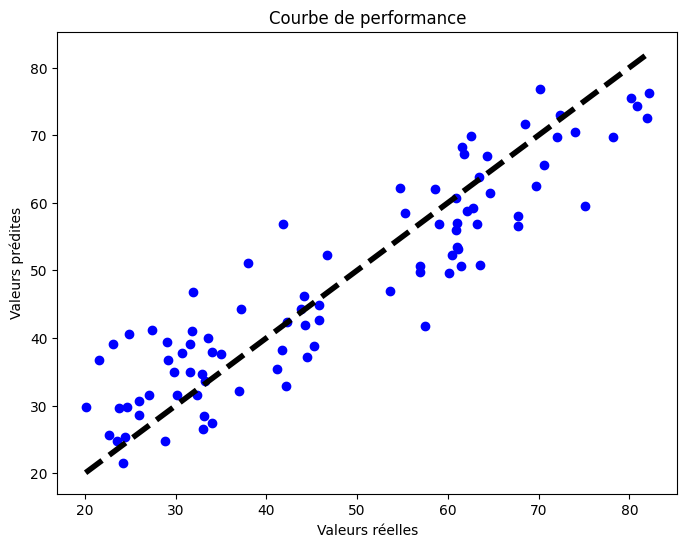

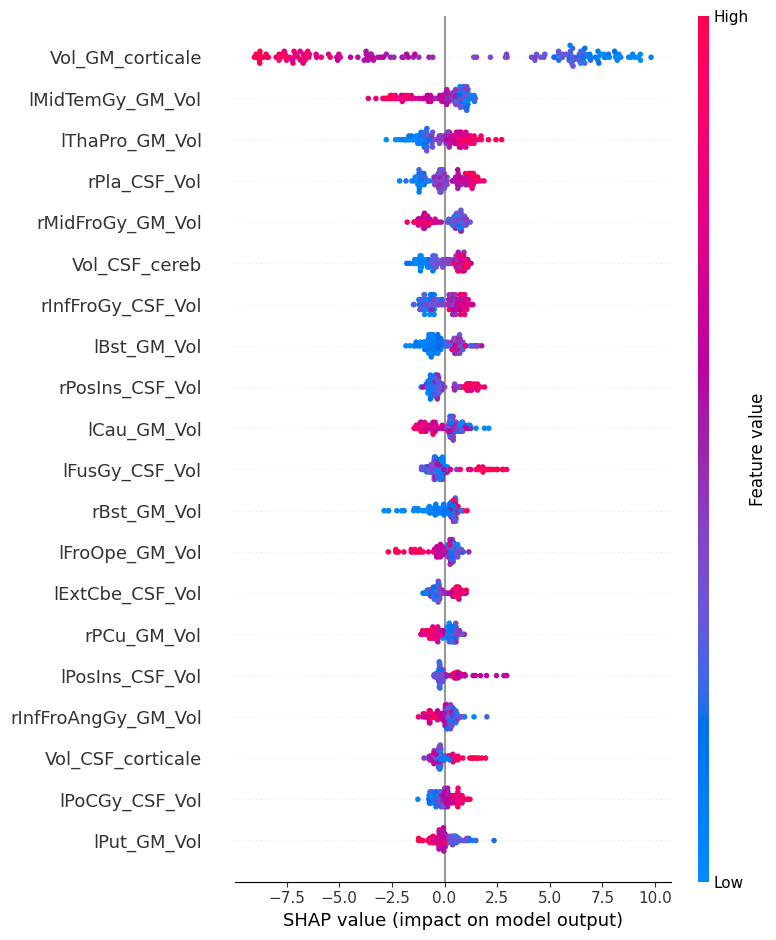

In [53]:
# Afficher la courbe de performance
plt.figure(figsize=(8, 6))
plt.scatter(y_test, pred, color='blue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)
plt.xlabel('Valeurs réelles')
plt.ylabel('Valeurs prédites')
plt.title('Courbe de performance')
plt.show()


explainer = shap.TreeExplainer(model)

# Calculer les Shapley values pour un échantillon de données
shap_values = explainer.shap_values(ROI_train[features_list].iloc[:150, :])
shap.summary_plot(shap_values, ROI_train[features_list].iloc[:150, :])

shap_values_single = explainer.shap_values(ROI_train[features_list].iloc[[0]])
shap.force_plot(explainer.expected_value, shap_values_single, ROI_train[features_list].iloc[[0]])